# Text Clustering

* Aimed to group unlabeled texts based on their semantics/meaning and their relationships.
* `Applications`: relationship detection, outlier detection, labeling/topic modeling, EDA etc.

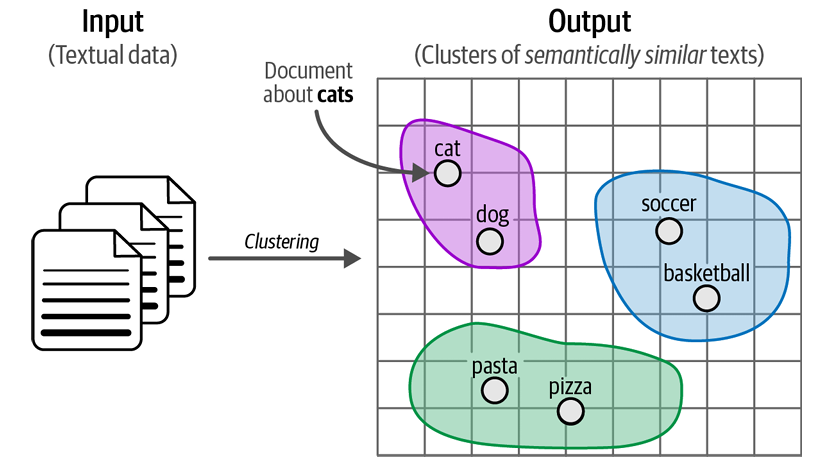

Steps followed for text clustering are:

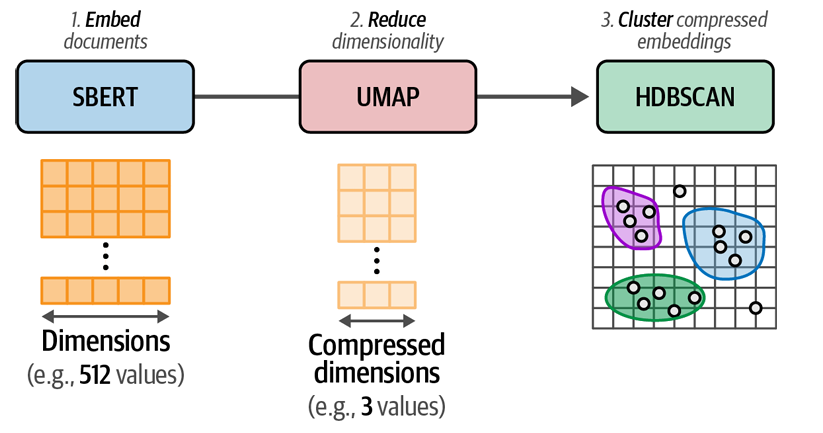

1. Embed the data
2. Reduce dimensionality - As the dimensionality increases, there is an exponenital growth in the number of possible values within each dimension, therefore finding a subspace for a cluster becomes difficult. Commonly used - PCA, Uniform Manifold Approximation and Projection (UMAP)
3. Clustering - centroid based clustering (K-means) required number of clusters to be denoted. Therefore, Density based clustering (HDBSCAN) is preffered and also it doesn't assign a label to outliers

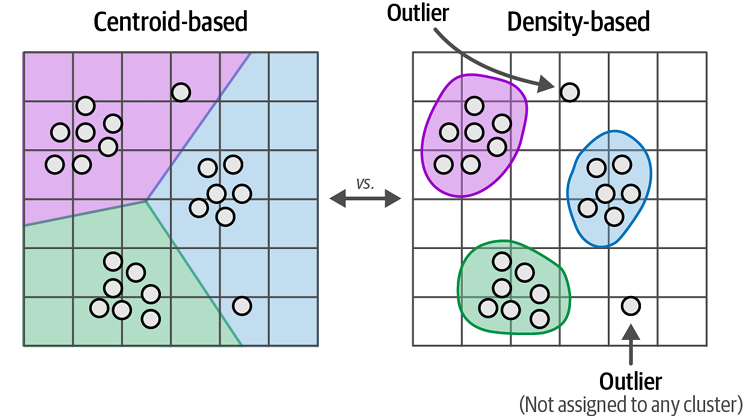

In [5]:
# load dataset - arXiv abstracts
from datasets import load_dataset

dataset = load_dataset("maartengr/arxiv_nlp")["train"]

In [3]:
# data
abstracts = dataset["Abstracts"]

# title
titles = dataset["Titles"]

In [4]:
# 1. Data embedding
from sentence_transformers import SentenceTransformer

# load embedding model
model = SentenceTransformer("thenlper/gte-small")

# embedding for each abstract
train_embed = model.encode(abstracts, show_progress_bar=True)

Batches:   0%|                                                                                | 0/1405 [00:00<?, ?it/s]C:\ProgramData\miniconda3\envs\gpu\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Batches: 100%|█████████████████████████████████████████████████████████████████████| 1405/1405 [03:59<00:00,  5.86it/s]


In [23]:
train_embed.shape

(44949, 384)

In [15]:
# 2. reduce dimensionality
from umap import UMAP

# reduce to 5d
umap_model = UMAP(n_components=5, min_dist=0.0, metric='cosine',  random_state=42)

# reduced embedding
red_train_embed = umap_model.fit_transform(train_embed)

C:\ProgramData\miniconda3\envs\gpu\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\miniconda3\envs\gpu\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [31]:
# HDBSCAN clustering is used
from hdbscan import HDBSCAN

# train model
hdbscan_clusters = HDBSCAN(min_cluster_size=50, metric="euclidean", cluster_selection_method="eom").fit(red_train_embed)

C:\ProgramData\miniconda3\envs\gpu\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\miniconda3\envs\gpu\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [34]:
# cluster labels
clusters = hdbscan_clusters.labels_

# number of clusters
len(set(clusters))

156

In [40]:
import numpy as np

# check a cluster
cluster = 2

# we can see the cluster is on job recruitment
for idx in np.where(clusters==cluster)[0][:4]:
    print(abstracts[idx][:100] + "...\n")

  Recruiters usually spend less than a minute looking at each r\'esum\'e when
deciding whether it's ...

  Job search through online matching engines nowadays are very prominent and
beneficial to both job ...

  In this report, we propose a new application for twitter data called
\textit{job detection}. We id...

  Employers actively look for talents having not only specific hard skills but
also various soft ski...



In [41]:
# for visualisation - reduce to 2d
umap_model = UMAP(n_components=2, min_dist=0.0, metric='cosine',  random_state=42)

# reduced embedding
red_train_embed = umap_model.fit_transform(train_embed)

C:\ProgramData\miniconda3\envs\gpu\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\miniconda3\envs\gpu\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [50]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(red_train_embed, columns=["X", "y"])

df["title"] = titles
df["cluster"] = clusters

# outlier and non outliers
for_plotting = df.loc[df["cluster"] != -1]
outliers = df.loc[df["cluster"] == -1]

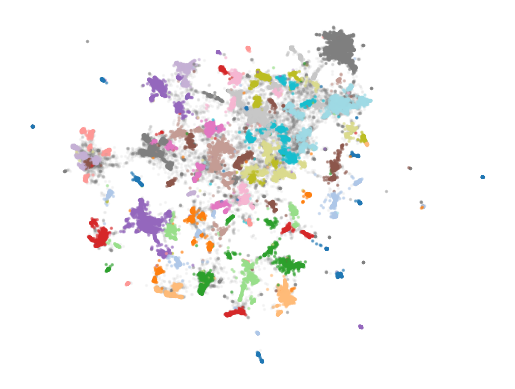

In [59]:
plt.scatter(outliers["X"], outliers["y"], alpha=0.05, s=2, c="grey")
plt.scatter(for_plotting["X"], for_plotting["y"], c=for_plotting["cluster"], alpha=0.5, s=2, cmap="tab20")

plt.axis("off")
plt.show()

# Topic modeling
* It is idea of finding the theme or topic for a document
* We saw the cluster 2's topic to be job recruitment.
* Earlier this was done using methods like keyword, bigrams (find topic using nearby words to the center word). latent dirichlet allocation etc.
* latent dirichlet allocation - topic is allocated by probability distribution of words. Done using BOW.

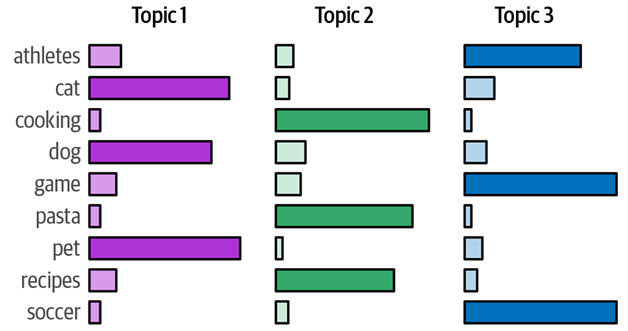

* This doesnt take context and semantics into consideration as we did using embedding model based clustering.

Done in two steps:
1. Follow same steps as for text classification
2. model the distribution of words within cluster (not document level as done commonly) using methods like BOW.
3. Use methods like TF-IDF to add weights that are unique to a cluster and reduce weights on words that are present across clusters (eg: or, the etc.)

TF - BOW word frequency\
IDF - $log\frac{Total\ number\ documents\ in\ a\ cluster}{Number\ of\ times\ the\ word\ appears\ in\ each\ document\ in\ the\ cluster}$

$$TF-IDF = TF \times IDF$$

eg: if `the` appears in all the documents in the cluster, then IDF = 0.

In clustering task specific model like `BERTopic`, **c-TF-IDF** is used.

c-IDF - $log\frac{avg\ frequency\ of\ all\ words\ across\ all\ cluster}{Number\ of\ times\ each \ word}$

Therefore, less weight if frequency > avg frequency.

eg: avg_freq_across_clusters = 29, the_freq_across _clusters = 58, recruitment_freq_across_clusters = 6. Therefore, more weightage to the term `recruitment` and negative weightage to the term `the`.

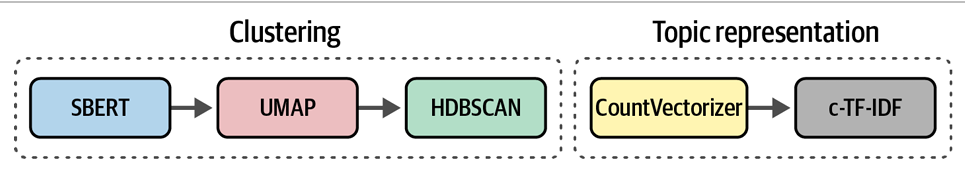

Note: CountVectorizer - from scikitlearn for BOW

In [71]:
from bertopic import BERTopic

# does step 1 and 2
topic_model = BERTopic(embedding_model=model,      # note other models can also be used
                      umap_model=umap_model,       # note other models can also be used
                      hdbscan_model=hdbscan_model, # note other models can also be used
                      verbose=True).fit(abstracts, train_embed)

2024-12-12 00:13:57,096 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-12 00:14:25,981 - BERTopic - Dimensionality - Completed ✓
2024-12-12 00:14:25,991 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-12 00:14:28,337 - BERTopic - Cluster - Completed ✓
2024-12-12 00:14:28,358 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-12 00:14:31,895 - BERTopic - Representation - Completed ✓


In [73]:
topic_model.get_topic_info().head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,13050,-1_of_the_and_to,"[of, the, and, to, in, we, that, for, language...",[ We describe a neural network model that joi...
1,0,2268,0_speech_asr_recognition_end,"[speech, asr, recognition, end, acoustic, audi...","[ In this paper, we introduce a new and simpl..."
2,1,1344,1_dialogue_dialog_response_responses,"[dialogue, dialog, response, responses, orient...",[ Traditional goal-oriented dialogue systems ...
3,2,1300,2_medical_clinical_biomedical_patient,"[medical, clinical, biomedical, patient, notes...",[ Electronic health records (EHR) contain nar...
4,3,985,3_summarization_summaries_summary_abstractive,"[summarization, summaries, summary, abstractiv...",[ Abstractive summarization systems generally...


We can see that the topics are represented by several keywords (clusters with the highest probabilities)

In [75]:
# topic is the top 4 highest probaility value
topic_model.get_topic(0)

[('speech', 0.028031865576848596),
 ('asr', 0.01832566869639679),
 ('recognition', 0.013256802836367033),
 ('end', 0.009995326235932855),
 ('acoustic', 0.00954550378836846),
 ('audio', 0.007056911619693484),
 ('speaker', 0.0066548001030229745),
 ('spoken', 0.006439067979363893),
 ('error', 0.00618427722339231),
 ('wer', 0.006158086517270576)]